In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pymc as pm
# import pymc_bart as pmb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.inspection import permutation_importance

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [3]:
data = pd.read_csv('NF_Descriptors.csv')
data = data.dropna()
y = data['LUMO_calc']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

param_grid = {
    "n_estimators": [0,10,50,100],
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = ExtraTreesRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy versio

Param for GS {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
CV score for GS 0.8782638612919104
Train AUC ROC Score for GS:  0.9303556637643168
Test AUC ROC Score for GS:  0.8809006499942231


Text(0.5, 1.0, 'LUMO')

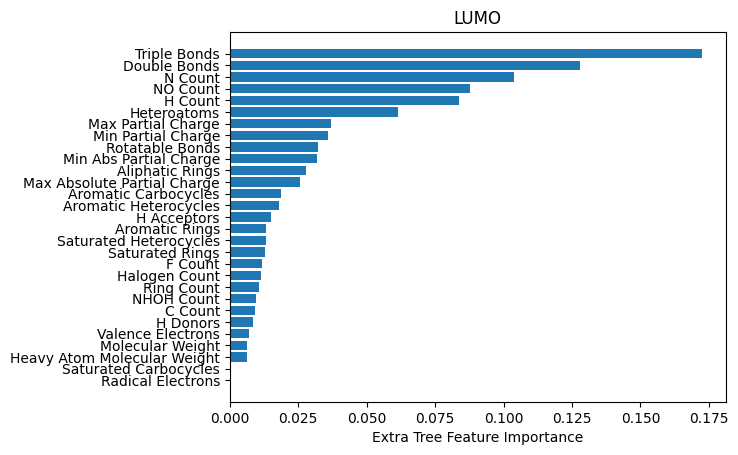

In [4]:
model = ExtraTreesRegressor(random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100)
model.fit(X_train, y_train)

sorted_idx = model.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Extra Tree Feature Importance")
plt.title("LUMO")

In [5]:
r = permutation_importance(model, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Double Bonds0.349 +/- 0.002
Triple Bonds0.312 +/- 0.002
H Count 0.134 +/- 0.001
N Count 0.128 +/- 0.001
NO Count0.118 +/- 0.001
Heteroatoms0.057 +/- 0.001
Rotatable Bonds0.056 +/- 0.001
Min Partial Charge0.040 +/- 0.000
Aliphatic Rings0.038 +/- 0.000
Max Partial Charge0.036 +/- 0.000
Min Abs Partial Charge0.031 +/- 0.000
Max Absolute Partial Charge0.025 +/- 0.000
Aromatic Carbocycles0.024 +/- 0.000
Aromatic Heterocycles0.017 +/- 0.000
Saturated Heterocycles0.012 +/- 0.000
F Count 0.011 +/- 0.000
Saturated Rings0.011 +/- 0.000
H Acceptors0.010 +/- 0.000
Aromatic Rings0.010 +/- 0.000
Halogen Count0.009 +/- 0.000
NHOH Count0.008 +/- 0.000
Ring Count0.007 +/- 0.000
H Donors0.007 +/- 0.000
C Count 0.006 +/- 0.000
Valence Electrons0.004 +/- 0.000
Molecular Weight0.003 +/- 0.000
Heavy Atom Molecular Weight0.003 +/- 0.000


In [6]:
model.fit(X_train, y_train)

r = permutation_importance(model, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Double Bonds0.312 +/- 0.004
Triple Bonds0.268 +/- 0.005
H Count 0.097 +/- 0.002
N Count 0.095 +/- 0.002
NO Count0.088 +/- 0.002
Rotatable Bonds0.044 +/- 0.001
Heteroatoms0.034 +/- 0.001
Aliphatic Rings0.024 +/- 0.001
Max Partial Charge0.022 +/- 0.001
Min Partial Charge0.022 +/- 0.001
Min Abs Partial Charge0.017 +/- 0.001
Aromatic Carbocycles0.013 +/- 0.001
Max Absolute Partial Charge0.011 +/- 0.000
Aromatic Heterocycles0.008 +/- 0.000
Saturated Heterocycles0.007 +/- 0.000
Saturated Rings0.006 +/- 0.000
F Count 0.005 +/- 0.000
Halogen Count0.004 +/- 0.000
NHOH Count0.004 +/- 0.000
H Donors0.003 +/- 0.000
Aromatic Rings0.002 +/- 0.000
H Acceptors0.001 +/- 0.000
Ring Count0.001 +/- 0.000


In [7]:
# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.16 degrees.


In [8]:
from sklearn.metrics import mean_squared_error

prediction = model.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = model.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

R2:  0.8588744062312026
MSE:  0.04200145724346562
RMSE:  0.20494257059836452


In [3]:
data = pd.read_csv('NF_Descriptors.csv')
data = data.dropna()
y = data['HOMO_calc']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

param_grid = {
    "n_estimators": [0,10,50,100],
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = ExtraTreesRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy versio

Param for GS {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
CV score for GS 0.9205883732493966
Train AUC ROC Score for GS:  0.9669442262562269
Test AUC ROC Score for GS:  0.9224300880127659


Text(0.5, 1.0, 'HOMO')

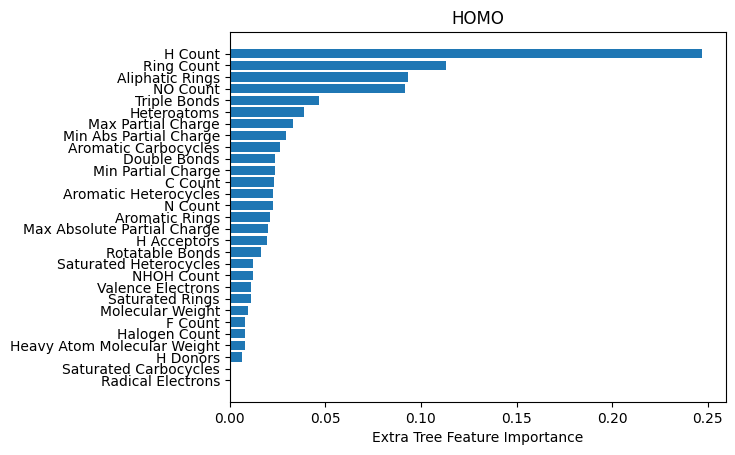

In [5]:
model = ExtraTreesRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model.fit(X_train, y_train)

sorted_idx = model.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Extra Tree Feature Importance")
plt.title("HOMO")

In [6]:
r = permutation_importance(model, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

H Count 0.408 +/- 0.003
Aliphatic Rings0.264 +/- 0.003
NO Count0.192 +/- 0.002
Ring Count0.188 +/- 0.002
Triple Bonds0.096 +/- 0.001
Aromatic Carbocycles0.048 +/- 0.001
Max Partial Charge0.039 +/- 0.001
Min Abs Partial Charge0.032 +/- 0.001
Double Bonds0.029 +/- 0.001
Heteroatoms0.028 +/- 0.001
Aromatic Heterocycles0.025 +/- 0.001
Min Partial Charge0.022 +/- 0.000
N Count 0.018 +/- 0.001
H Acceptors0.016 +/- 0.000
Saturated Rings0.015 +/- 0.000
Max Absolute Partial Charge0.015 +/- 0.000
Saturated Heterocycles0.014 +/- 0.000
Rotatable Bonds0.014 +/- 0.002
C Count 0.013 +/- 0.000
Aromatic Rings0.012 +/- 0.000
NHOH Count0.011 +/- 0.000
Halogen Count0.006 +/- 0.000
F Count 0.005 +/- 0.000
Valence Electrons0.005 +/- 0.000
Molecular Weight0.005 +/- 0.000
H Donors0.004 +/- 0.000
Heavy Atom Molecular Weight0.004 +/- 0.000


In [7]:
model.fit(X_train, y_train)

r = permutation_importance(model, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

H Count 0.351 +/- 0.006
Aliphatic Rings0.219 +/- 0.008
NO Count0.157 +/- 0.008
Ring Count0.155 +/- 0.010
Triple Bonds0.076 +/- 0.007
Aromatic Carbocycles0.040 +/- 0.005
Max Partial Charge0.030 +/- 0.003
Min Abs Partial Charge0.019 +/- 0.002
Double Bonds0.015 +/- 0.004
Saturated Rings0.013 +/- 0.000
Saturated Heterocycles0.012 +/- 0.000
Heteroatoms0.011 +/- 0.004
NHOH Count0.010 +/- 0.000
H Acceptors0.006 +/- 0.002
C Count 0.004 +/- 0.001
H Donors0.003 +/- 0.000


In [8]:
# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

from sklearn.metrics import mean_squared_error

prediction = model.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = model.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

Mean Absolute Error: 0.11 degrees.
R2:  0.903837260549201
MSE:  0.034344379028306726
RMSE:  0.1853223651594883
